In [1]:
import pandas as pd
import os
from scipy.stats import skew, kurtosis
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
from optimizers.simulations.order import simulate_lqe_model
from optimizers.utils._utils import get_csv_data
from optimizers.cross_validators import vbt_cv_sliding_constructor
from research.pipes.sql import SQLPipe

load_dotenv()

USER = os.getenv('psql_username')
PASS = os.getenv('psql_password')
DATABASE = 'crypto'
SCHEMA = 'bihourly'

pipe = SQLPipe(SCHEMA, DATABASE, USER, PASS, interval='30T')

In [2]:
assets = ['TRX-USDT', 'ETH-USDT']
slicer = 0 # Slice off first few months of trading to reduce early volatility

df = pipe.query_pairs_trading_backtest(assets)
closes = df.xs('close', level=1, axis=1)[slicer:]
opens = df.xs('open', level=1, axis=1)[slicer:]
assert closes.shape[0] > 8640, 'Less than 1 year of backtesting data present'
assert closes.shape == opens.shape, 'Open and close shape does not match'

print(f"Full data length: {closes.shape[0]}")

n = 5
train_opens, opens = train_test_split(opens, test_size=0.30, train_size=0.70, shuffle=False)
train_closes, closes = train_test_split(closes, test_size=0.30, train_size=0.70, shuffle=False)
close_folds = vbt_cv_sliding_constructor(train_closes, n_splits=n)
open_folds = vbt_cv_sliding_constructor(train_opens, n_splits=n)

print(f"Test data length: {opens.shape[0]}")
print(f"Train fold length {close_folds[0].shape[0]}")

Full data length: 66258
Test data length: 19878
Train fold length 9276


In [11]:
opens

,TRX-USDT,ETH-USDT
2021-08-12 21:00:00,0.084041,3066.09
2021-08-12 21:30:00,0.083541,3049.40
2021-08-12 22:00:00,0.083299,3043.82
2021-08-12 22:30:00,0.082499,3007.10
2021-08-12 23:00:00,0.082150,2999.48
...,...,...
2022-09-30 21:30:00,0.061074,1329.36
2022-09-30 22:00:00,0.060965,1323.20
2022-09-30 22:30:00,0.060948,1325.25
2022-09-30 23:00:00,0.060925,1322.45


In [3]:
# EOS FIL works on a CUMMLOG model but has volatility in per trade returns
# FIL THETA & LINK CHZ, BTC ZEC. BTCZEC might work, but had generalization issues
# ADA ZEC is untestable due to massive regime shift mid test set for LOG model
# Something is bizarre and wrong with the ADA ZEC data; needs review?
# BSV 1INCH 70 2.1 -2.4 1.3 5.000000e-07 0.00030 CUMMLOG <- does not work past 10bps slippage
# XLM1INCH, LTCCHZ, DGBCAKE, NEODGB, DGBDASH, GRT1INCH failed backtesting
# THETA FIL 100 1.2 -1.2 0.3 9.e-8 4.e-5 LOG seems to work
# BATANKR 303 0.7 -2.7 0.4 3.e-9 1.7e-5 LOG
# LTCCHZ works, but apparently failed to hedge (same issue as with CHZWIN) <- this might be fixed now
# BNBTRX (LOG) failed
# BNBTRX CUMMLOG 615 1.9 -2.2 1.4 8e-6 0.3 <- low sharpe, but high WR. High duration. Deploy with minor alloc?
# XLM SUN / SUN XLM  does not generalize well. Low trade count, high duration
# XMR ETH failed across all models. Still need to test ETH XMR
# ASX VRA DEFAULT 20 2.0 -1.8 0.6 8e-8 1.2 <- extremely successful
# DOGE SUN / SUN DOGEfailed on all models
# FIL CAKE DEFAULT 510 1.6 -1.4 0.1 6e-6 7e-1 returned low trade count, high duration, but ~2 sharpe, high wr, high pr. Bears live testing
# THETA FIL LOG 355 1.5 -1.5 1.2 1E-9 0.15 works quite well at 20bps slippage. Fat tail risk in trades leads to low sharpe
# EOS CAKE does not work on any metric; XMR CAKE LOG failed

PERIOD = 1625
UPPER = 2.3
LOWER = -0.5
EXIT = 1.6
DELTA = 3e-5
VT = 1.5e-3
BURNIN = 800
MODEL = 'log'
HEDGE = 'beta'
SLIPPAGE = 0.0010
FREQ = '30T'

In [4]:
pf = simulate_lqe_model(
    closes, opens,
    period=PERIOD,
    upper=UPPER,
    lower=LOWER,
    exit=EXIT,
    delta=DELTA,
    vt=VT,
    burnin=BURNIN,
    freq=FREQ,
    hedge=HEDGE,
    transformation=MODEL,
    slippage=SLIPPAGE,
    order_size=0.10,
)

-0.23786746425246427


<AxesSubplot:>

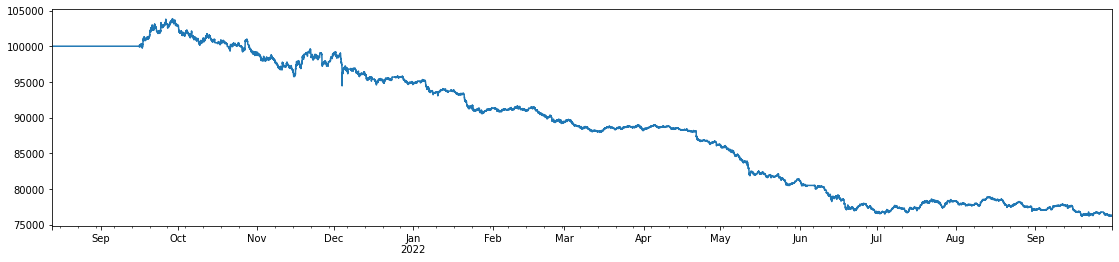

In [5]:
print(pf.total_return())
pf.value().plot(figsize=(19,4))

In [6]:
pnl = (pf.trades.records_readable.groupby('Entry Timestamp').sum().PnL.resample('D').sum())
val = pf.value().resample('D').asfreq().fillna(pf.value())
res = pd.concat([pnl, val], axis=1, keys=['pnl', 'val'])
res = res.fillna(0)
res['ret'] = res.pnl / res.val
Rf = (1 + 0) ** (1/365) - 1 # Daily risk free rate
Rp = res.ret.mean() # Daily portfolio return
STDp = res.ret.std() # Daily standard deviation of return
sharpe = ((Rp - 0) / STDp) * np.sqrt(365) # Annualized sharpe

In [7]:
res = pf.trades.records_readable.groupby("Entry Timestamp").sum()

print(f"Total trades: {res.shape[0]}")
print(f"Executed trades: {pf.trades.records_readable.shape[0]}")
print(f"Profit Ratio: {res.PnL[res.PnL > 0].mean() / np.abs(res.PnL[res.PnL < 0].mean()):.3f}")
print(f"Net long-short win rate: {res.PnL[res.PnL > 0].shape[0] / res.shape[0] * 100:.2f}%")
print(f"Median trade profit: {res.PnL.median():.2f}")
print(f"Mean trade profit: {res.PnL.mean():.2f}")
print(f"STD of trade profit: {res.PnL.std():.2f}")
print(f"Sharpe ratio: {sharpe:.4f}")

Total trades: 350
Executed trades: 700
Profit Ratio: 0.622
Net long-short win rate: 46.86%
Median trade profit: -7.53
Mean trade profit: -67.96
STD of trade profit: 388.64
Sharpe ratio: -3.1193


<AxesSubplot:xlabel='Entry Timestamp'>

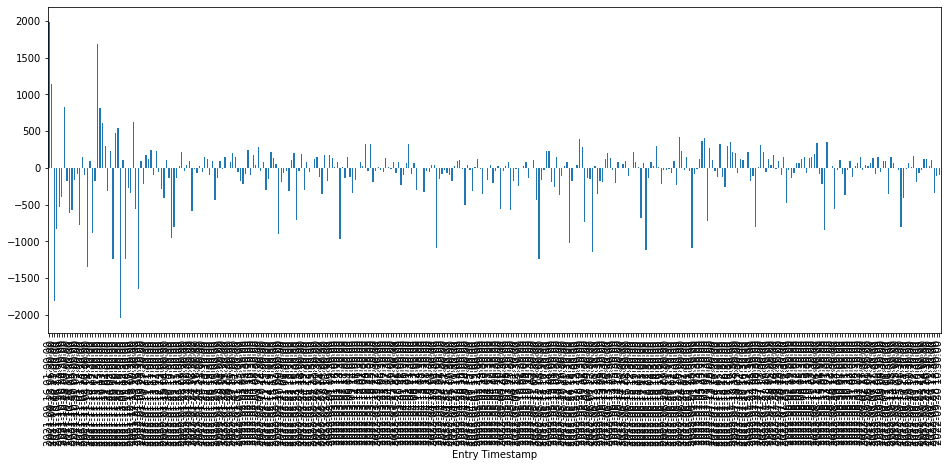

In [8]:
res.PnL.plot(kind="bar", figsize=(16,6))

Kurtosis: 10.341321197297338
Skew: -0.8156247371019846


<AxesSubplot:ylabel='Frequency'>

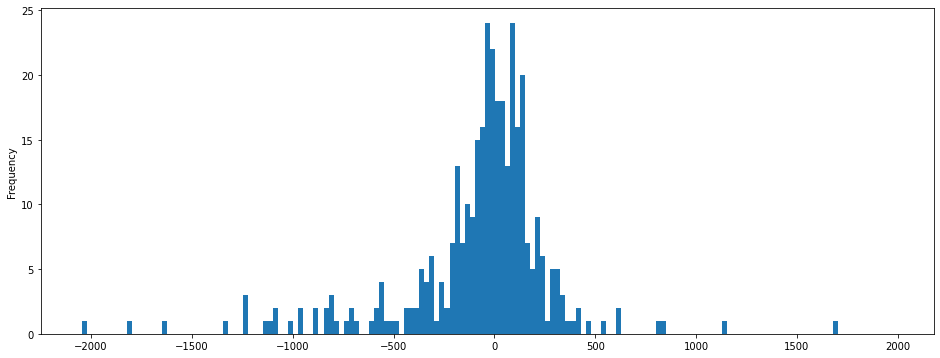

In [9]:
print(f'Kurtosis: {kurtosis(res.PnL, fisher=False)}')
print(f'Skew: {skew(res.PnL)}')

bins = np.arange(res.PnL.min(), res.PnL.max(), 25)
res.PnL.plot(kind="hist", figsize=(16,6), bins=bins)
